In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt


Load the dataset form directory

In [2]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 50
n_classes = 3

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory('PlantVillage', 
                                                   shuffle=True, 
                                                   image_size=(IMAGE_SIZE, IMAGE_SIZE),
                                                    batch_size=BATCH_SIZE) 

Found 2152 files belonging to 3 classes.


In [4]:
class_names = dataset.class_names
class_names # Three classes 0, 1, 2

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [5]:
len(dataset) # 32(batch size) * 68 = 2176 almost the no of images

68

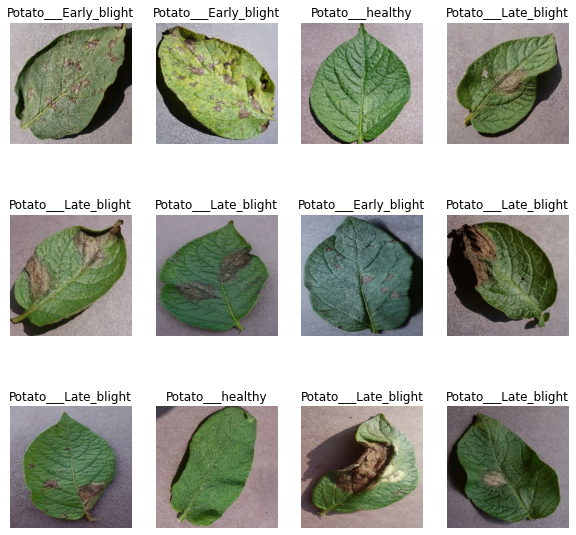

In [6]:
plt.figure(figsize=(10, 10)) # Increase each figure size
for image_batch, labels_batch in dataset.take(1) : #Only one batch
 for i in range(12) :
    # print(image_batch.shape)
    # image_batch[0].numpy() # To convert from tensor to numpy
    plt.subplot(3, 4, i+1)
    plt.imshow(image_batch[i].numpy().astype('uint8')) # Plot the image
    plt.axis('off')
    plt.title(class_names[labels_batch[i]]) # Getting the class name
    # print(labels_batch.numpy())

##### Split dataset
Total = 2162 images

80 % ==> Training set

10% ==> Test set

10% ==> Validation set

In [7]:
train_size = 0.8
train_num = int(len(dataset)*train_size)

In [8]:
train_ds = dataset.take(train_num) # First 54 images
len(train_ds)

54

In [9]:
rem_ds = dataset.skip(54)

In [10]:
val_size = 0.1
val_ds = rem_ds.take(6)
test_ds = rem_ds.skip(6)
len(test_ds)

8

Function fro partitioning the dataset 

In [11]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000) :
    
    ds_size = len(ds)

    if shuffle :
     ds = ds.shuffle(shuffle_size, seed=12)

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    test_size = int(test_split * ds_size)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size + val_size)

    return train_ds, val_ds, test_ds

In [12]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [13]:
train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
# cache will read the image from the disk and keep them in memory
# prefetch will make cpu to take next batch and load

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

Resize and Scale the images

In [14]:
resize_and_scale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

Data Augmentation

In [15]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip('horizontal_and_vertical'),
    layers.experimental.preprocessing.RandomRotation(0.2),
])

#### Model Building

In [16]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

model = models.Sequential([
    resize_and_scale,
    data_augmentation,
    layers.Conv2D(32, (3, 3), activation='relu', input_shape = input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu', input_shape = input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu', input_shape = input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu', input_shape = input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu', input_shape = input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu', input_shape = input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax')
])

model.build(input_shape=input_shape)



In [17]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (32, 127, 127, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 62, 62, 64)         0         
 2D)                                                  

In [18]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy']
)

In [19]:
history = model.fit(
    train_ds,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=val_ds
)

Epoch 1/50
54/54 [==============================] - 117s 2s/step - loss: 0.8972 - accuracy: 0.5100 - val_loss: 0.8423 - val_accuracy: 0.6615
Epoch 2/50
54/54 [==============================] - 105s 2s/step - loss: 0.6930 - accuracy: 0.6731 - val_loss: 0.6409 - val_accuracy: 0.6786
Epoch 3/50
54/54 [==============================] - 107s 2s/step - loss: 0.4849 - accuracy: 0.7859 - val_loss: 0.4894 - val_accuracy: 0.7917
Epoch 4/50
54/54 [==============================] - 106s 2s/step - loss: 0.3154 - accuracy: 0.8727 - val_loss: 0.3149 - val_accuracy: 0.8594
Epoch 5/50
54/54 [==============================] - 104s 2s/step - loss: 0.2096 - accuracy: 0.9120 - val_loss: 0.1608 - val_accuracy: 0.9427
Epoch 6/50
54/54 [==============================] - 104s 2s/step - loss: 0.1801 - accuracy: 0.9208 - val_loss: 0.3334 - val_accuracy: 0.8542
Epoch 7/50
54/54 [==============================] - 104s 2s/step - loss: 0.1648 - accuracy: 0.9384 - val_loss: 0.0746 - val_accuracy: 0.9688
Epoch 8/50
54

In [20]:
model.save('Potato_Project_1.h5')

In [21]:
scores = model.evaluate(test_ds)

8/8 [==============================] - 6s 500ms/step - loss: 0.2277 - accuracy: 0.9414


In [22]:
scores # Loss and accuracy

[0.22772200405597687, 0.94140625]

In [23]:
history

In [24]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 54}

In [26]:
history.history.keys() # Each of 50 values

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [30]:
history.history['accuracy']

[0.5099765062332153,
 0.6731220483779907,
 0.7858796119689941,
 0.8726525902748108,
 0.9119718074798584,
 0.9207746386528015,
 0.9383803009986877,
 0.9483568072319031,
 0.9518779516220093,
 0.9659624695777893,
 0.9688966870307922,
 0.9653756022453308,
 0.9278169274330139,
 0.9248826503753662,
 0.9518779516220093,
 0.9694835543632507,
 0.9706572890281677,
 0.966549277305603,
 0.9724178314208984,
 0.9735915660858154,
 0.9762731194496155,
 0.9818075299263,
 0.9806337952613831,
 0.9882628917694092,
 0.9882628917694092,
 0.9866898059844971,
 0.9826388955116272,
 0.9800469279289246,
 0.9878472089767456,
 0.9894366264343262,
 0.9812206625938416,
 0.9901620149612427,
 0.9923709034919739,
 0.9791666865348816,
 0.9823943376541138,
 0.98591548204422,
 0.9923709034919739,
 0.9739583134651184,
 0.9855324029922485,
 0.9906103014945984,
 0.9953051805496216,
 0.9841549396514893,
 0.9853286147117615,
 0.9900234937667847,
 0.9812206625938416,
 0.9847418069839478,
 0.9785879850387573,
 0.9906103014945984

Text(0.5, 1.0, 'Training and Validation Loss')

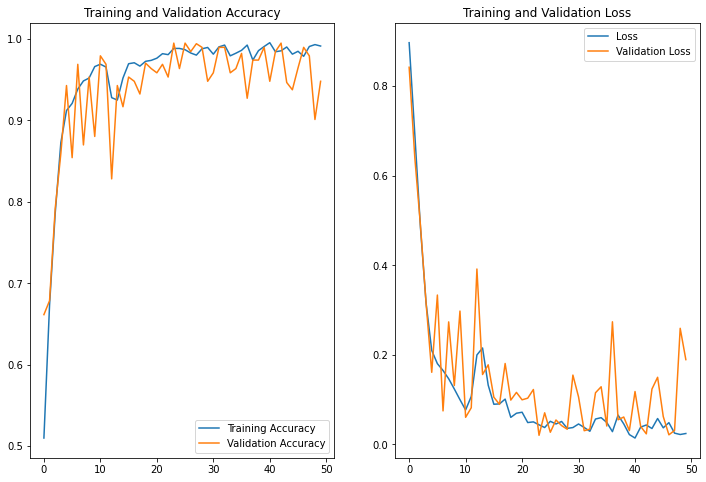

In [40]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss  = history.history['val_loss']

plt.figure(figsize=(12,8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')


first image to predict
first image actual label : Potato___healthy
Predicted label : Potato___healthy


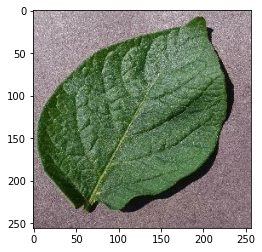

In [51]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0]

    print(f'first image to predict')
    plt.imshow(first_image)
    print(f'first image actual label : {class_names[first_label]}')

    batch_prediction = model.predict(images_batch)
    print(f'Predicted label : {class_names[np.argmax(batch_prediction[0])]}') # MAximum value of he class

In [84]:
def predict(model, img) :
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0) # Create a batch

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

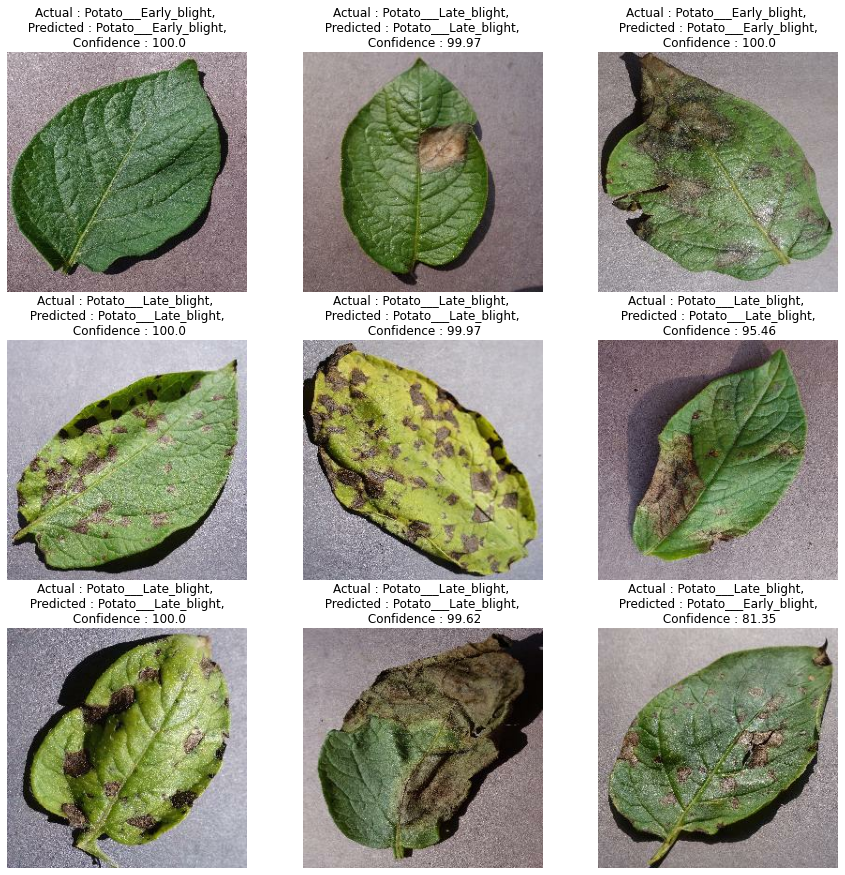

In [86]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1) :
    for i in range(9) :
        ax = plt.subplot(3, 3, i+1)
        plt.imshow(images_batch[i].numpy().astype('uint8'))

        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]

        plt.title(f'Actual : {actual_class}, \n Predicted : {predicted_class}, \n Confidence : {confidence}')
        
        plt.axis('off')
        


In [95]:
import os
model_version = max([int(i) for i in os.listdir('/models') + [0]]) + 1
model.save(f'models/{model_version}') # f'../models/{model_version} to save model in Models folder 